# Course overview

> Getting started

In [1]:
# !pip install -q datasets diffusers transformers accelerate

In [28]:
from typing import List
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
from base64 import b64encode
from diffusers import UNet2DConditionModel
import torch
from diffusers import AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer, logging as tsmrs_logging
import requests
from PIL import Image
from torchvision import transforms as tfms
from io import BytesIO
import requests
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm, trange

In [3]:
# Supress some unnecessary warnings when loading the CLIPTextModel
tsmrs_logging.set_verbosity_error()

In [4]:
!nvidia-smi

Fri Jun 30 01:15:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#|export
TORCH_DEVICE = "cuda" if torch.cuda.is_available else "cpu"

## Overview

https://course.fast.ai/Lessons/lesson9.html

Consider, we can have images at varying levels of bluriness.

In [6]:
mnist = load_dataset("mnist")
img = np.array(mnist["train"][0]["image"])
img = normalize(img)
img_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.2
img_very_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.8

  0%|          | 0/2 [00:00<?, ?it/s]

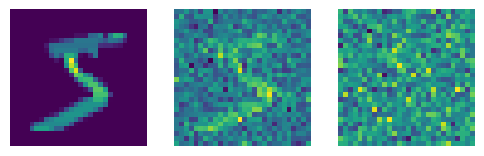

In [7]:
#|export
def show_images(imgs, titles=None, aspect_ratio=2):
    fig_size = (aspect_ratio * len(imgs), aspect_ratio)
    fig, axes = plt.subplots(1, len(imgs), figsize=fig_size)

    for i, (ax, img) in enumerate(zip(axes if len(imgs) > 1 else [axes], imgs)):
        if titles:
            ax.set(title=titles[i])
        ax.set_axis_off()
        ax.imshow(img)

imgs = [img, img_blurry, img_very_blurry]
show_images(imgs)

We can imagine a probability distribution over the image, which is a function, $P$, of $28^2$ variables (one for each pixel).

Recall that mutlivariate calculus is concerned with partial derivatives. For example, the partial derivatives of $f(x,y)=x^2 + y^2$ are:

$$
\begin{align}
\frac{\partial f(x,y)}{\partial x} &= 2x \\
\frac{\partial f(x,y)}{\partial y} &= 2y \\
\end{align}
$$

In the case of an image, imagine the partial derivative of the function $P$ with respect to a *single pixel*:

$$
\frac{\partial P(X)}{\partial X_{i,j}} = \frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}
$$

This gives us a way of altering the image from less likely and blurrier images to more likely and crisper images. An algorithm could look something like this:

- For all pixel values $X_{i,j} \in X$, evaluate the partial derivative $\frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}$ or $\frac{\partial P(X)}{\partial X_{i,j}}$. This can also be expressed as $\nabla_X P$
- For some hyperparameter constant $C$ and for all pixel values $X_{i,j} \in X$, $X_{i,j} := X_{i,j} + C \frac{\partial P(X)}{\partial X_{i,j}}$ or, equivalently, $X := X + C \cdot \nabla_X P$
- Repeat until satisfied

In PyTorch, this would look something like:

```python
X = get_image()
# Somewhat unusually, you would incorporate the image as a model
# parameter in order to get auto-differentiation
model = get_nabla_X_of_P_model(X=X)
for _ in range(n_timesteps):
	p_grad = model.forward(X)
	p_grad.backward()
	model.X += C * model.X.grad
```


In fact, we don't have $P(X)$ or $\nabla_X P(X)$ in real life. But we can solve a related problem.

Notice that $\nabla_X P(X)$ provides a direction from blurrier to sharper images. We can train a neural network to de-blur by adding the blur ourselves. The input-output pair would be $\langle image + \epsilon, \epsilon \rangle$ where $\epsilon \sim \mathcal{N}(0, \Sigma)$ and $\Sigma \in \mathbb{R}^{28^2 \times 28^2}$

The model that does so, for Stable Diffusion, is a U-Net

In [8]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(TORCH_DEVICE)

## Noise Scheduling

Because Stable Diffusion originated in research in differential equations, we generally have $t$ as an input parameter. DiTORCH_DEVICEnt amounts of noise are added at different time steps.

[Text(0.5, 0, 'Time'), Text(0, 0.5, '$\\beta$')]

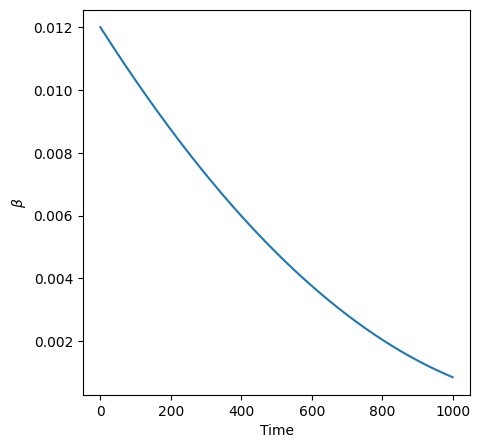

In [13]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(scheduler.timesteps, scheduler.betas)
ax.set(xlabel="Time", ylabel=r"$\beta$")

Since the amount of noise is a function of time, giving the model access to $t$ can help its performance. Therefore, the input-output pair becomes  $\langle \left( image + \epsilon, t \right), \epsilon \rangle$.

This is similiar in many respects to gradient descent. We can think of $C$ as the learning rate; the principle difference is that the model would not have access to $t$.

## Prompt Conditioning

One thing we could add to make the problem easier is to indicate the image class (1, 2, 3, etc). For a simple class distribution, we could just one hot-encode it.  The input-output pair would then be $\langle \left( image + \epsilon, t, class \right), \epsilon \rangle$.

But we cannot one-hot encode the distribution of images on the internet à la Stable Diffusion. Therefore, we need a more sophisticated encoder: CLIP (**C**onstrastively **L**earned **I**mage **P**airs). This works on the idea that the dot-product between image encoding and text encoding of the *same thing* should be large, while the image encoding and text encoding for *different things* should be small.

We learn this with a neural network contrastively. For a given batch, $B$,  of (image, language) pairs from html `alt` tags:

- Compute the encoding $f_{image}(I_i)$ and $f_{language}(L_i)$ for all $i \in |B|$

- Compute the sum $\text{correctly paried loss} := \Sigma_i^{|B|} f_{image}(I_i) \cdot f_{language}(L_i)$

- Compute the sum

$$
\text{incorrectly paired loss} := \Sigma_i^{|B|} \Sigma_j^{|B|}  \begin{cases}
    f_{image}(I_i) \cdot f_{language}(L_j) & i \neq j\\
    0 & i = j
  \end{cases}
$$

- Final loss = `incorrectly paired loss` - `correctly paired loss`. Note that want the overall loss to be small or negative, so we take the negative of the sum of the correctly paired dot products. This pushes the vectors for correctly paired language image to be in the same subspace, and incorrectly paired counterparts into different subspaces.

![](https://github.com/jeremyadamsfisher/SlowAI/blob/main/images/CLIP.jpg?raw=1)

`transformers` has a CLIP module that allows text tokenization and encoding.

In [14]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = text_encoder.to(TORCH_DEVICE)

In [15]:
prompt = "A photo of a giraffe"
tokens = tokenizer(prompt, return_tensors="pt").input_ids
tokens

tensor([[49406,   320,  1125,   539,   320, 22826, 49407]])

In [16]:
with torch.no_grad():
    text_embeddings = text_encoder(tokens.to(TORCH_DEVICE)).last_hidden_state
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.1565,  0.1318,  0.7895,  ..., -2.1024, -1.1519, -0.3311],
         ...,
         [ 0.5830, -0.1372,  2.1518,  ..., -1.0520, -0.1529,  0.0968],
         [ 0.3015, -0.7548,  1.3880,  ..., -1.0459,  0.1620,  0.8099],
         [-1.5782, -0.7593,  0.4279,  ..., -1.1564, -0.2069,  1.1331]]],
       device='cuda:0')

## VAE Pre-/post-processing

Another thing we can do is, instead of training directly on pixel values, use the latents of a Variational Autoencoder (VAE). This can give a dramatic reduction in the number of parameters to train.

In [17]:
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="vae",
    low_cpu_mem_usage=True,
).to(TORCH_DEVICE)

In [19]:
#|export
to_tensor = tfms.ToTensor()

VAE_TO_UNET_SCALING_FACTOR = 0.18215

def pil_to_latent(img, vae):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    img = to_tensor(img).unsqueeze(0).to(vae.device)
    img = img * 2 - 1 # Note scaling
    with torch.no_grad():
        latents = vae.encode(img)
    return VAE_TO_UNET_SCALING_FACTOR * latents.latent_dist.sample()

def image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return np.array(image)

For example, we can compress this image of Weird Al...

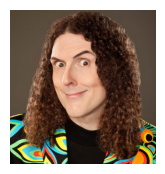

In [20]:
img = image_from_url(
    "https://www.perfectduluthday.com/wp-content/uploads/2021/12/Weird_Al_Yankovic_profile.jpg"
)
show_images([img])

By a factor of ~50x

In [21]:
latents = pil_to_latent(img, vae)
n_params_img = np.product(img.shape)
n_params_latents = np.product(latents.shape)
f"{n_params_latents / n_params_img:.2f}x"

'0.02x'

Each of the channels contains a more semantically rich representation of the image for the model to work with.

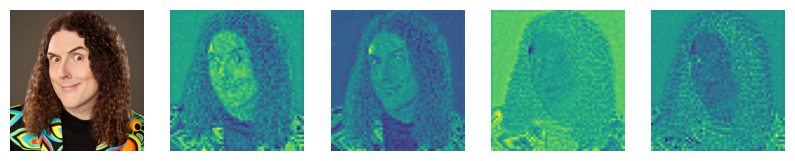

In [22]:
l = latents.squeeze().cpu().numpy()
imgs = [l[i, ...] for i in range(4)]
show_images([img, *imgs])

Despite that, it decompresses without any issue.

In [23]:
#|export
def decompress(latents, vae):
    with torch.no_grad():
        img = vae.decode(latents / VAE_TO_UNET_SCALING_FACTOR).sample
    img = (img / 2 + 0.5).clamp(0,1)
    # color dimension goes last for matplotlib
    img = img.permute(0, 2, 3, 1)
    img = img.cpu().numpy().squeeze()
    return img

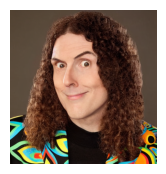

In [24]:
img = decompress(latents, vae)
show_images([img])

From the perspective of the model, this is only one of many sorts of images -- for the most part, it looks at blurry images.

This is what adding noise does. Once projected into the image dimension, it's not Guassian like in the latent space.

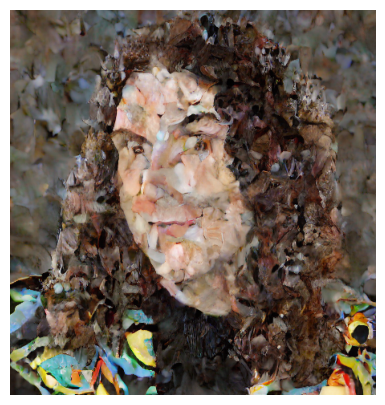

In [25]:
noise = torch.randn(latents.shape, device=latents.device)
noised_latents = latents * 0.6 + noise * 0.4
img = decompress(noised_latents, vae)
show_images([img], aspect_ratio=5)

# An aside, mathematics

# Math Deep Dive



This is an overview of the mathematics of the [DDPM (denoising diffusion probability models) paper](https://arxiv.org/abs/2006.11239) by Ho et al (2020).

The best overview of the mathematics here is found at the [assembly.ai blog](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/).

In mathematical parlance, we seek to fit a set of reverse Markov transitions to maximize the likelihood of the model on the training data. Or "minimizing the variational upper bound on the negative log likelihood." Not sure what that mean exactly, but I'll be targetting the mathematical level of myself 6 months ago.

First, we define some terms:

- $X^{(0)}$ is the input data distribution; for example, MNIST digits
- $Q$ and $P$ are probability density functions
- $\beta_t$ is the "noise value" at time t

We can look to physics for inspiration in AI. This paper draws from the thermodynamics to imagine the opposite of a diffusion process: that is, evolving for a high-entropy distribution (like a noisy image) to a clear one.

In the diffusion process, we have a **"forward" **Gaussian Markov process called $Q$ that governs the transition to a noisier distribution. In nature, this is a Guassian distribution:
$$
Q(X^{(t)} | X^{(t-1)}) = \mathcal{N}(X^{(t-1)}\sqrt{1-\beta_t}, I\beta_t)
$$
Note that at $t=0$, we haven't added any noise and $B_0=0$. In fact, there is a simple expected value:
$$
\begin{align}
E\left[\mathcal{N}(X^{(t-1)}\sqrt{1-\beta_t}, I\beta_t)\right]
&= E\left[\mathcal{N}(X^{(t-1)}\sqrt{1-(0)}, I(0)\right]\\
&= E\left[\mathcal{N}(X^{(t-1)}, 0)\right] \\
&= X^{(t-1)}

\end{align}
$$
Furthermore, note that adding noise is a simple process and we generally work with the "analytic" conditional distribution where we all the noise all at once. We'll go over this function later.

The important process to consider, however, is the "backward" Guassian Markov process called $P$


$$
Q(X^{(t)} | X^{(t-1)}) = \mathcal{N}(\square(X^{(t-1)}), \triangle(X^{(t-1)}))
$$

We want a function that maximizes the log-likelihood of this probability distribution on the data. Mathematically, this would involve the integral over the parameters and likelihood. This is mathematically intractable.

(An aside, we use log-likelihood instead of likelihood because it increases monotonically and sums are more numerically stable on computers than products.)

Instead of solving the integral directly, we use the **E**vidence **L**ower **Bo**und. This is a score function of the model that balances maximizing the likelihood of the data under the model with the complexity of the model.
$$
ELBO = E\left[log(P_\theta(X))\right] - KL(q(\theta) || p(\theta))
$$
The expectation maximization term calculates the probability of the data using the PDF $P$. The likelier the data under the model, the lower the loss. Simple.

In general, KL divergence measures the difference between distributions. In our case, it is a loss that should be minimized between the expected (or "variational") weight distribution ($p$) and the actual ("true posterior") distribution ($q$) of the model weights themselves. Basically, we want to see the same distributions in the reverse process that we would see in the forward process.

 The $||$ is a notation for the computation:
$$
KL(q || p) = \int q(\theta)log\left( \frac{q(\theta)}{{p(\theta)}} \right) d\theta
$$
Let's break this down. 

- The log ratio of the point values of $p$ and $q$ at $\theta$ is a measure of the difference at that point
  - If the probability distributions give the same likelihood for $\theta$, the resulting value is 0
  - As $q(\theta)$ goes 0 and $p(\theta)$  goes to 1, the limit of the resulting value diverges to negative infinity
  - As $q(\theta)$ goes 1 and $p(\theta)$  goes to 0, the limit diverges to positive infinity
- $q(\theta)$ is a weight for the integrand

So, in sum, the KL diverenge is a sum of the difference in probability weighted by the probability values of the variational distribution. If the distributions are similar, the KL divergence is small; otherwise, they are large.

See: https://www.assemblyai.com/blog/content/media/2022/05/KL_Divergence.mp4

Interestingly, Ho et al fixes the variance schedule. In turns out, this makes it so that the **covariance matrix is constant, the KL divergence term goes to 0 and we only need to estimate the mean**, i.e.: fit a function to $\square(X^{(t-1)})$.

We can train a model to do so with MSE loss.


# Putting things together



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.


0it [00:00, ?it/s]

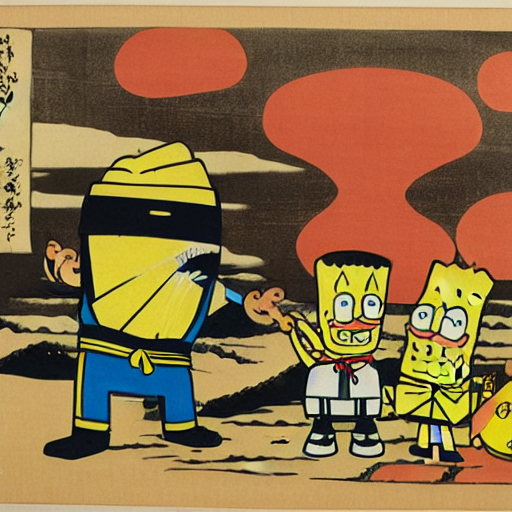

In [26]:
# Some settings
prompt = ["A ukiyo-e painting of spongebob doing karate"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(TORCH_DEVICE))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(TORCH_DEVICE))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(TORCH_DEVICE)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with torch.autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [30]:
@dataclass
class StableDiffusion:
    rng = torch.manual_seed(32)
    tokenizer: CLIPTokenizer
    text_encoder: CLIPTextModel = text_encoders
    scheduler: LMSDiscreteScheduler = scheduler
    unet: UNet2DConditionModel = unet
    
    @torch.no_grad()
    def get_text_embedding(self, s: str):
        tokens_conditional = self.tokenizer(
            [s],
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids.to(TORCH_DEVICE)
        
        embedding_conditional = self.text_encoder(tokens_conditional).last_hidden_state

        # conditional and unconditional embeddings need to be the same length
        _, n_tokens = tokens_conditional.shape
        tokens_unconditional = self.tokenizer(
            [""],
            padding="max_length",
            max_length=n_tokens,
            return_tensors="pt",
        ).input_ids.to(TORCH_DEVICE)
        
        embedding_unconditional = self.text_encoder(tokens_unconditional).last_hidden_state
        
        return torch.cat([embedding_unconditional, embedding_conditional])
        
    @torch.no_grad()
    def sample(self, latents, t, text_embeddings, guidance_scale):
        inp_ = torch.cat([latents, latents])
        inp_ = self.scheduler.scale_model_input(inp_, t)
        noise_pred = unet(
            latent_model_input,
            t, 
            encoder_hidden_states=text_embeddings,
        ).sample
        noise_pred_unconditional, noise_pred_conditional = noise_pred
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond)

        
        noise_pred = (
            noise_pred_unconditional + guidance_scale * 
        )
        
        
    @torch.no_grad()
    def __call__(self, prompt, guidance_scale=7.0, n_inference_steps=30):
        self.scheduler.set_timesteps(n_inference_steps)
        
        text_embedding = self.get_text_embedding(prompt)
        
        # Initialize latents
        latents = torch.randn(
            (1, self.unet.in_channels, 64, 64),
            generator=self.rng,
        ).to(TORCH_DEVICE)
        latents *= scheduler.init_noise_sigma
        
        for t in trange(n_inference_steps, unit="step"):
            latents = self.sample(latents, t, text_embedding, guidance_scale)
        
        return self.get_text_tokens(prompt)
    
sd = StableDiffusion(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    scheduler=scheduler,
    unet=unet,
)
sd("A ukiyo-e painting of spongebob doing karate")

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│         noise_pred =                                                                             │
│                     ▲                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [29]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969,